# Capstone Project for the Data Science Specialization

### Rafael Y. Imai - April 2021

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


Firstly, let's load the datasets with the investment funds CNPJ (similar to a company ID in Brazil, can be used to identify uniquely a given investment fund),the share value at a given date, along with the volume of subscriptions and redemptions in Brazilian Reais:

In [76]:
historicSeries = pd.DataFrame()
for year in range(2017,2021):
    for month in range(1,13):
        file = "CVMData/inf_diario_fi_{0}{1}.csv".format(year,str(month).zfill(2))
        historicSeries = historicSeries.append(pd.read_csv(file, sep = ";"))
    print("{} inserted.".format(year))

historicSeries=historicSeries[["CNPJ_FUNDO","DT_COMPTC","VL_TOTAL","VL_QUOTA","VL_PATRIM_LIQ","CAPTC_DIA","RESG_DIA","NR_COTST"]]


2018 inserted.
2019 inserted.
2020 inserted.


Also, let's load a dataset with all of the investment funds that have existed since the early 90's in Brazil. This file was also obtained from CVM.

In [77]:
fundList = pd.read_excel("cad_fi.xlsx")
fundList=fundList.rename(columns={'CNPJ_FUNDO':'CNPJ'})

#### Another dataset that we will use is the historic series of the IBOVESPA index, the stock market index for the São Paulo Stock Exchange.

In [78]:
ibov = yf.Ticker('^BVSP')
ibovHistoric = ibov.history(start="2016-12-31",end="2021-1-1")
ibovHistoricClose = ibovHistoric[["Close"]] 
ibovHistoricClose = ibovHistoricClose.rename(columns={'Date':'DATE',"Close":"CLOSE"}) 

#### Random stuff about the SELIC rate

In [79]:
selicData = pd.read_json("http://api.bcb.gov.br/dados/serie/bcdata.sgs.4189/dados?formato=json&dataInicial=01/01/2017&dataFinal=31/12/2020")
selicData.head()
selicData["data"]=pd.to_datetime(selicData.data)
selicData = selicData.set_index("data") 

In [80]:
historicSeries['CAP_LIQ']=historicSeries['CAPTC_DIA']-historicSeries['RESG_DIA']
historicSeries['TKT_MED']=historicSeries['VL_PATRIM_LIQ']/historicSeries['NR_COTST']

Some peculiarities of the Brazilian investment fund market must be observed. Among the funds present on the first selection, there might be exclusive funds (funds with a single shareholder or a select set of shareholders, that may apply in illiquid assets and not be subjected to frequent subscriptions and redemptions). As one of the main objects of this work is to assess whether macroeconomic variables have a significant impact on the volume of subscriptions and redemptions, it is interesting to filter out funds that are not subject to a regular volume of subscriptions and redemptions.

In this case, I will use the portfolio of IHFA, a market index provided by ANBIMA, an association whose members are companies involved with the financial sector in Brazil. IHFA stands for *Índice de Hedge Funds ANBIMA*, ANBIMA Hedge Funds Index in a literal translation. The portfolio selection criteria involve, among other rules, a minimum of ten shareholders and the exclusion of such exclusive funds.

More info can be found (in portuguese) at this link: https://www.anbima.com.br/pt_br/informar/precos-e-indices/indices/ihfa.htm.

The portfolio of the last quarter of 2020 will be used to assemble a list of funds, as it corresponds roughly to the end of the selected period. I had to post-process the portfolio file manually, as only a general report including some statistics about the index and the portfolio composition is published. The original file can be found here https://www.anbima.com.br/data/files/04/35/26/3E/E9E057106A070057882BA2A8/IHFA%20-%204T20.xlsx, but I will use a manually assembled Excel spreadsheet to store the CNPJ and the hedge fund names.

In [81]:
ihfaFirstQuarter20 = pd.read_excel("ANBIMAData/1Q2020-IHFA.xlsx")
ihfaFirstQuarter20.shape

(244, 2)

On the scope of this study, only common Investment Funds ("FI") will be considered. Every form of Investment Fund in Brazil is regulated by CVM, so funds that have a specific purpose (e.g., FUNCINE funds, special investment funds whose objective is to support the movie industry) and certain funds that are closed-end funds (such as FII - Fundos de Investimento Imobiliário or Real Estate Investment Funds, similar to REITs) will be discarded.



Also, in order to provide a consistent first sample, only funds that happened to exist between December 31, 2016 and today or existed in January 1, 2017 and were closed in 2021 were considered.

In [103]:
def mount_FirstLayer(lowerLimit,upperLimit):
    firstFundFilterLayer = fundList[((fundList["TP_FUNDO"]=="FI")
                                 &(((fundList["DT_REG"]<lowerLimit)&(fundList["DT_CANCEL"]>upperLimit))
                                   |((fundList["DT_REG"]<lowerLimit)&(fundList["SIT"]=="EM FUNCIONAMENTO NORMAL"))))]
    return firstFundFilterLayer

In [104]:
def mount_FinalLayers(firstFundFilterLayer):
    secondFundFilterLayer = firstFundFilterLayer[firstFundFilterLayer["DENOM_SOCIAL"].str.contains("COTA")]
    tagsFixedIncome = [' RENDA FIXA ',' RF ']

    fixedIncomeFundFilterLayer = secondFundFilterLayer[secondFundFilterLayer["DENOM_SOCIAL"].str.contains('|'.join(tagsFixedIncome))]
    #fixedIncomeFundFilterLayer[['CNPJ_FUNDO','DENOM_SOCIAL']]

    tagsPrivateBonds = [' CP ',' CRED PRIV ',' CRÉD PRIV ',' CRED. PRIV. ',' CRÉD. PRIV. ',' CRÉDITO PRIVADO ', ' CREDITO PRIVADO ']


    privateBondsFundFilterLayer = secondFundFilterLayer[secondFundFilterLayer["DENOM_SOCIAL"].
                                                        str.contains('|'.join(tagsPrivateBonds))]

    tagsInterbankRate = [' REFERENCIADO DI ', ' REF DI ']
    interbankRateFundFilterLayer = secondFundFilterLayer[secondFundFilterLayer["DENOM_SOCIAL"].str.contains('|'.join(tagsInterbankRate))]
    
    return [fixedIncomeFundFilterLayer,privateBondsFundFilterLayer,interbankRateFundFilterLayer]

In [105]:
lowerLimit = "2017-12-31"
upperLimit = "2020-12-31"
firstFundFilterLayer = mount_FirstLayer(lowerLimit,upperLimit)
filters = mount_FinalLayers(firstFundFilterLayer)
fixedIncomeFundFilterLayer = filters[0]
privateBondsFundFilterLayer = filters[1]
interbankRateFundFilterLayer = filters[2]

Afterwards, funds that use a master-feeder structure (a feeder fund that receive subscriptions and subscribes to a master fund, the fund that actually purchase securities and stock) will be filtered, considering only feeders (in portuguese, Fundos de Investimento em Cotas de Fundos de Investimentos).

In [106]:
def run_standard_analysis(historicSeries,fundList):
    
    dumpColumns = ['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']
    
    insightsFund = pd.DataFrame()
    insightsFund_SELIC = pd.DataFrame()
    insightsFund_Flow = pd.DataFrame()
    insightsFund_AvgTicket = pd.DataFrame()
    insightsFund_Dump = pd.DataFrame(columns=dumpColumns)

    dailyStatsHistoricSeries=historicSeries[historicSeries["CNPJ_FUNDO"].isin(fundList["CNPJ"])]
    dailyStatsHistoricSeries=dailyStatsHistoricSeries.rename(columns={'CNPJ_FUNDO':'CNPJ',"DT_COMPTC":"DATE"})
 
    for cnpj in fundList['CNPJ']:
        historicFundTemp = dailyStatsHistoricSeries[dailyStatsHistoricSeries['CNPJ']==cnpj]    
        historicFundTemp.set_index("DATE", inplace = True)  
        historicFundTemp = historicFundTemp.join(ibovHistoricClose)    
        historicFundTemp = historicFundTemp.dropna()
        historicFundTemp = historicFundTemp.join(selicData)
        
        
        
        stockCorrelation = [[cnpj,historicFundTemp[["NR_COTST","CLOSE"]].corr().iloc[1,0]]]
        SELICCorrelation = [[cnpj,historicFundTemp[["NR_COTST","valor"]].corr().iloc[1,0]]]
        flowCorrelation = [[cnpj,historicFundTemp[["NR_COTST","CAP_LIQ"]].corr().iloc[1,0]]]
        avgTicketCorrelation = [[cnpj,historicFundTemp[["NR_COTST","TKT_MED"]].corr().iloc[1,0]]]   
        vol = [[cnpj,historicFundTemp["VL_QUOTA"].std()/historicFundTemp["VL_QUOTA"].mean()]]
        
        insightsFund = insightsFund.append(stockCorrelation)   
        insightsFund_SELIC = insightsFund_SELIC.append(SELICCorrelation) 
        insightsFund_Flow = insightsFund_Flow.append(flowCorrelation) 
        insightsFund_AvgTicket = insightsFund_AvgTicket.append(avgTicketCorrelation) 
        
    insightsFund_Dump=insightsFund_Dump.append({'CNPJ':cnpj,'IbovCorrelation':stockCorrelation[0][1],'SELICCorrelation':SELICCorrelation[0][1],'flowCorrelation':flowCorrelation[0][1],'avgTicketCorrelation':avgTicketCorrelation[0][1],'vol':vol[0][1]},ignore_index=True)
    
    return [insightsFund, insightsFund_SELIC, insightsFund_Flow, insightsFund_AvgTicket, insightsFund_Dump]

In [107]:
def plot_graphs(insightsFund, insightsFund_SELIC, insightsFund_Flow, insightsFund_AvgTicket, binCount, main_Title):
    fig, axs = plt.subplots(1, 4, sharex=False, sharey=False)
    fig.set_size_inches(11,4)
    plt.suptitle(main_Title)

    axs[0].hist(insightsFund[[1]], bins=11)
    axs[0].set_title("shareholders vs stock market index")
    axs[0].set_xlabel("Correlations")
    axs[0].set_ylabel("# Funds")  


    axs[1].hist(insightsFund_SELIC[[1]], bins=11)
    axs[1].set_title("shareholders vs SELIC rates")
    axs[1].set_xlabel("Correlations")
    axs[1].set_ylabel("# Funds")  

    axs[2].hist(insightsFund_Flow[[1]], bins=11)
    axs[2].set_title("shareholders vs capital flow")
    axs[2].set_xlabel("Correlations")
    axs[2].set_ylabel("# Funds")  

    axs[3].hist(insightsFund_AvgTicket[[1]], bins=11)
    axs[3].set_title("shareholders vs avg ticket")
    axs[3].set_xlabel("Correlations")
    axs[3].set_ylabel("# Funds")      

    plt.tight_layout()
    plt.show()

### IHFA

In [89]:
ihfaHistoricSeries = historicSeries[historicSeries["CNPJ_FUNDO"].isin(ihfaFirstQuarter20["CNPJ"])]
ihfaHistoricSeries = ihfaHistoricSeries.rename(columns={'CNPJ_FUNDO':'CNPJ',"DT_COMPTC":"DATE"})

results = run_standard_analysis(historicSeries,ihfaFirstQuarter20)
insightsIhfa = results[0]
insightsIhfa_SELIC = results[1]
insightsIhfa_Flow = results[2]
insightsIhfa_AvgTicket = results[3]
insightsIhfa_Dump = results[4]
plot_graphs(insightsIhfa, insightsIhfa_SELIC, insightsIhfa_Flow, insightsIhfa_AvgTicket,11,"IHFA Funds Results")

#### Interbank Rate Funds

In [91]:
interbankHistoricSeries = historicSeries[historicSeries["CNPJ_FUNDO"].isin(interbankRateFundFilterLayer["CNPJ"])]
interbankHistoricSeries = interbankHistoricSeries.rename(columns={'CNPJ_FUNDO':'CNPJ',"DT_COMPTC":"DATE"})


results = run_standard_analysis(historicSeries,interbankRateFundFilterLayer)
insightsInterbankRate = results[0]
insightsInterbankRate_SELIC = results[1]
insightsInterbankRate_Flow = results[2]
insightsInterbankRate_AvgTicket = results[3]
insightsInterbankRate_Dump = results[4]

plot_graphs(insightsInterbankRate, insightsInterbankRate_SELIC, insightsInterbankRate_Flow, insightsInterbankRate_AvgTicket,11,"Interbank Rate Funds Results")

#### Fixed Income Rate Funds

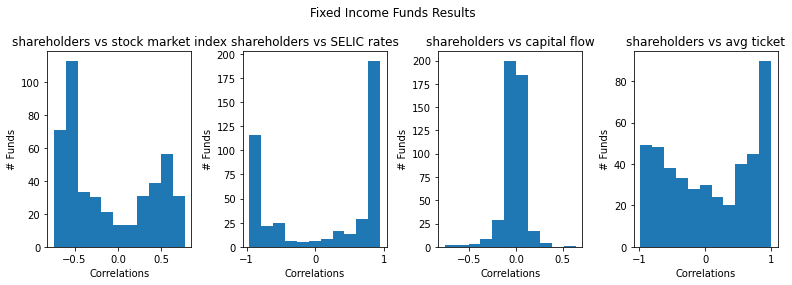

In [93]:
fixedIncomeHistoricSeries = historicSeries[historicSeries["CNPJ_FUNDO"].isin(fixedIncomeFundFilterLayer["CNPJ"])]
fixedIncomeHistoricSeries = fixedIncomeHistoricSeries.rename(columns={'CNPJ_FUNDO':'CNPJ',"DT_COMPTC":"DATE"})


results = run_standard_analysis(historicSeries,fixedIncomeFundFilterLayer)
insightsFixedIncome = results[0]
insightsFI_SELIC = results[1]
insightsFI_Flow = results[2]
insightsFI_AvgTicket = results[3]
insightsFI_Dump = results[4]

plot_graphs(insightsFixedIncome, insightsFI_SELIC, insightsFI_Flow, insightsFI_AvgTicket,11,"Fixed Income Funds Results")

#### Private Bond Funds

In [94]:
privateBondHistoricSeries = historicSeries[historicSeries["CNPJ_FUNDO"].isin(privateBondsFundFilterLayer["CNPJ"])]
privateBondHistoricSeries = privateBondHistoricSeries.rename(columns={'CNPJ_FUNDO':'CNPJ',"DT_COMPTC":"DATE"})


results = run_standard_analysis(historicSeries,privateBondsFundFilterLayer)
insightsPrivateBonds = results[0]
insightsPB_SELIC = results[1]
insightsPB_Flow = results[2]
insightsPB_AvgTicket = results[3]
insightsPB_Dump = results[4]

plot_graphs(insightsPrivateBonds, insightsPB_SELIC, insightsPB_Flow, insightsPB_AvgTicket,11,"Private Bond Funds Results 2017-2020")

### Yearly analysis

In [109]:
historicSeries.head()

,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST,CAP_LIQ,TKT_MED
0,00.017.024/0001-53,2018-01-02,1130197.89,25.968274,1130221.60,0.0,0.0,1,0.0,1130221.60
1,00.017.024/0001-53,2018-01-03,1130497.24,25.972772,1130417.38,0.0,0.0,1,0.0,1130417.38
2,00.017.024/0001-53,2018-01-04,1130796.56,25.977238,1130611.74,0.0,0.0,1,0.0,1130611.74
3,00.017.024/0001-53,2018-01-05,1131096.62,25.981703,1130806.07,0.0,0.0,1,0.0,1130806.07
4,00.017.024/0001-53,2018-01-08,1131087.37,25.986184,1131001.11,0.0,0.0,1,0.0,1131001.11


In [96]:
#unload

insightsIhfa_Dump.to_csv("ihfa_dump.csv")
insightsFI_Dump.to_csv("fixedIncome_dump.csv")
insightsInterbankRate_Dump.to_csv("interbankRate_dump.csv")
insightsPB_Dump.to_csv("privateBond_dump.csv")